In [1]:
import sys
import os
from datetime import datetime
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import logging
from datetime import datetime
import traceback

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, LeaveOneOut
from sklearn.utils.multiclass import unique_labels

from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    RocCurveDisplay, auc, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix, classification_report,
    balanced_accuracy_score, roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
import re
import scipy



pd.set_option('display.max_columns', None)

sys.path.append(os.path.abspath("../src"))  

def bold_max(df, dataset="", precision=2):
    """
    Return a Styler that bolds the column-wise maxima.

    Works with both:
    - numeric values
    - strings in the format '0.84 ± 0.02'

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with either numeric or 'mean ± std' strings.
    dataset : str
        A caption or title to display above the table.
    precision : int, default 2
        Number of decimals to show if numeric.
    """
    def is_string_with_std(val):
        return isinstance(val, str) and '±' in val
    
    def is_string_with_bracket(val):
        return isinstance(val, str) and '[' in val

    if df.applymap(is_string_with_std).all().all():
        # All cells are strings with ±
        def highlight_max(col):
            means = col.str.extract(r"(\d+\.\d+) ±")[0].astype(float)
            max_val = means.max()
            return ['font-weight: bold' if v == max_val else '' for v in means]

        return df.style.set_caption(f"Dataset: {dataset}").apply(highlight_max, axis=0)

    else:
        # Assume numeric DataFrame
        return (
            df.style
              .set_caption(f"Dataset: {dataset}")
              .format(f"{{:.{precision}f}}")
              .apply(lambda col: ['font-weight: bold' if v == col.max() else '' for v in col], axis=0)
        )


In [2]:
processed_path = '../data/processed/'
# Read data
df_digital_tmt_with_target = pd.read_csv(processed_path + 'df_digital_tmt_with_target.csv') 
demographic_df = pd.read_csv(processed_path + 'demographic_df.csv') 
non_digital_df = pd.read_csv(processed_path + 'non_digital_df.csv') 
df_digital_hand_and_eye = pd.read_csv(processed_path + 'df_digital_hand_and_eye.csv') 
digital_test_less_subjects = pd.read_csv(processed_path + 'digital_test_less_subjects.csv') 
non_digital_test_less_subjects = pd.read_csv(processed_path + 'non_digital_test_less_subjects.csv') 


# Final checks
print(df_digital_tmt_with_target['group'].value_counts())
print(demographic_df['group'].value_counts())
print(non_digital_df['group'].value_counts())
print(df_digital_hand_and_eye['group'].value_counts())
print(digital_test_less_subjects['group'].value_counts())
print(non_digital_test_less_subjects['group'].value_counts())

group
1    41
0    33
Name: count, dtype: int64
group
1    41
0    33
Name: count, dtype: int64
group
1    41
0    33
Name: count, dtype: int64
group
1    29
0    23
Name: count, dtype: int64
group
1    29
0    23
Name: count, dtype: int64
group
1    29
0    23
Name: count, dtype: int64


## Training

In [40]:
# Configure logging
# Ensure logs folder exists
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
# Create a fresh log file each run
log_filename = os.path.join(log_dir, f"error_log_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.log")
logging.basicConfig(filename=log_filename,
                    level=logging.ERROR,
                    format='%(asctime)s - %(levelname)s - %(message)s')


# ───────────────────────────────────────────────────────────────
# 0. SET-UP GENERAL 
# ───────────────────────────────────────────────────────────────
n_splits = 2
n_repeats = 1

global_seed = 42
inner_cv_seed = 50  # Fixed for reproducibility in inner CV
perform_pca = False
type_of_csv = 'loo'
n_components = 4
tune_hyperparameters = False
feature_selection = True


datasets = [
            ## N=74
            # 'demographic', 
            # 'digital_test', 
            'demographic+digital',
            # 'non_digital_tests', 
            # 'non_digital_tests+demo',

            ## less subjects
            # 'demographic_less_subjects', 
            # 'digital_test_less_subjects', 
            # 'demographic+digital_less',
            # 'hand_and_eye',
            # 'hand_and_eye_demo',
            # 'non_digital_test_less_subjects', 
            # 'non_digital_test_less_subjects+demo'
            ]

# datasets = ['non_digital_test_less_subjects+demo']


def extract_X_y_features(df):
    df = df.drop('suj', axis=1)
    print("group in X", 'group' in df.iloc[:, :-1].columns)
    print("suj in X", 'suj' in df.iloc[:, :-1].columns)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    feature_names = df.columns[:-1]
    assert 'suj' not in df.columns , "'suj' still in the final dataframe"
    return X, y, feature_names 

def join_and_reorder(df1, df2):
    df =  pd.merge(
        df1,
        df2.drop(columns='group'),
        on='suj',  
        how='inner' 
    )
    cols = [col for col in df.columns if col != 'group'] + ['group']
    df = df[cols]
    assert df.columns[-1] == 'group', "'group' is not the last column after reordering"
    return df

for value in [True, False]: 
    perform_pca = value
    for dataset in datasets:
        try:
            print(f"Starting {dataset}: \n\n")
            if perform_pca:
                print("Performing PCA")

            match dataset:
                case 'demographic':
                    X, y, feature_names = extract_X_y_features(demographic_df)

                case 'demographic_less_subjects':  
                    df = demographic_df.loc[df_digital_hand_and_eye.index]
                    X, y, feature_names = extract_X_y_features(df)

                case 'demographic+digital':
                    df = join_and_reorder(df_digital_tmt_with_target, demographic_df)
                    X, y, feature_names = extract_X_y_features(df)

                case 'demographic+digital_less':
                    df = join_and_reorder(df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index], demographic_df)
                    X, y, feature_names = extract_X_y_features(df)

                case 'non_digital_tests':
                    X, y, feature_names = extract_X_y_features(non_digital_df)

                case 'non_digital_tests+demo':
                    df = join_and_reorder(non_digital_df.drop(columns='suj'), demographic_df)
                    X, y, feature_names = extract_X_y_features(df)

                case 'non_digital_test_less_subjects':
                    X, y, feature_names = extract_X_y_features(non_digital_test_less_subjects)

                case 'non_digital_test_less_subjects+demo':
                    df = join_and_reorder(non_digital_test_less_subjects.drop(columns='suj'), demographic_df)
                    X, y, feature_names = extract_X_y_features(df)

                case 'digital_test':
                    X, y, feature_names = extract_X_y_features(df_digital_tmt_with_target)

                case 'digital_test_less_subjects':
                    X, y, feature_names = extract_X_y_features(digital_test_less_subjects)

                case 'hand_and_eye':
                    X, y, feature_names = extract_X_y_features(df_digital_hand_and_eye)

                case 'hand_and_eye_demo':
                    df = join_and_reorder(df_digital_hand_and_eye, demographic_df)
                    X, y, feature_names = extract_X_y_features(df)

                case _:
                    raise ValueError(f'Please select a valid dataset from: {datasets}')



            # ───────────────────────────────────────────────────────────────
            # 1. DEFINICIÓN DE PARÁMETROS Y MODELOS 
            # ───────────────────────────────────────────────────────────────

            unique, counts = np.unique(y, return_counts=True)
            print("Class distribution:", dict(zip(unique, counts)))

            # Define parameter grids
            param_grids = {
                "RandomForestClassifier": {
                    "classifier__n_estimators": [100, 500, 700, 1000],
                    "classifier__max_depth": [None, 10, 20, 30]
                },
                "SVC": {
                    "classifier__C": [0.1, 1, 10],
                    "classifier__kernel": ['linear', 'rbf']
                },
                "LogisticRegression": {
                    "classifier__C": [0.1, 1, 10],
                    "classifier__penalty": ['l2']
                },
                "XGBClassifier": {
                    "classifier__n_estimators": [100, 300],
                    "classifier__max_depth": [3, 5],
                    "classifier__learning_rate": [0.05, 0.1]
                }
            }

            # Define models to evaluate
            models = [
                RandomForestClassifier(random_state=42, n_jobs=-1),
                SVC(random_state=42, probability=True),
                LogisticRegression(max_iter=1000, random_state=42, solver='saga', n_jobs=-1),
                xgb.XGBClassifier(random_state=42, tree_method="hist", eval_metric='logloss',n_jobs=-1)
            ]

            # ───────────────────────────────────────────────────────────────
            # 2. Cross validation
            # ───────────────────────────────────────────────────────────────

            match type_of_csv:
                case 'stratified':
                    print(f"RepeatedStratifiedKFold selected with n_splits = {n_splits} and n_repeats = {n_repeats}")
                    outer_cv = RepeatedStratifiedKFold(
                        n_splits=n_splits,
                        n_repeats=n_repeats,         
                        random_state=global_seed # Global seed
                    )
                case 'loo':
                    print("LeaveOneOut selected")
                    outer_cv = LeaveOneOut()
                case _:
                    print("select a valid CV type")

            mean_fpr = np.linspace(0, 1, 100)
            all_metrics_df = pd.DataFrame(columns=[
                'model', 'repeat', 'fold',   
                'accuracy', 'balanced_accuracy', 'precision', 
                'recall', 'f1', 'auc', 'specificity'
            ])

            # ───────────────────────────────────────────────────────────────
            # 3. External loop 
            # ───────────────────────────────────────────────────────────────
            for model in models:
                model_name = model.__class__.__name__
                print(f"\n🧪 CV for: {model_name}")

                tprs, aucs, best_params_list, fold_metrics = [], [], [], []
                feature_importance_counts = {n: 0 for n in feature_names}

                # fig, ax = plt.subplots(figsize=(6, 6))
                all_y_true, all_y_pred = [], []

                # Enumeramos 'repeat' y 'fold' para guardar en métricas
                for outer_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
                    n_features = 20
                    n_components = 4
                    fold = outer_idx  # index of the left-out observation
                    print('fold:', fold)

                    # ── Split
                    X_train, X_test = X[train_idx], X[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]

                    
                    # ── Inner CV: estratificado 3-fold con la MISMA semilla por repetición
                    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=inner_cv_seed)
                    
                    if perform_pca:
                        n_components = min(n_components, X_train.shape[1])
                        print("n_components:", n_components)
                        pca_step = ('pca', PCA(n_components=n_components))
                    else:
                        pca_step = ('noop', 'passthrough')

                    
                    if feature_selection:
                        n_features = min(n_features, X_train.shape[1])
                        print("n_features:", n_features)
                        feature_selection_step = ('select', SelectKBest(score_func=f_classif, k=n_features))
                    else:
                        feature_selection_step = ('noop', 'passthrough')

                    pipeline = Pipeline([
                        ('imputer', SimpleImputer(strategy='mean')),  # or 'median' depending on your data
                        feature_selection_step,
                        ('scaler', StandardScaler()),
                        pca_step,
                        ('classifier', model)
                    ])

                    # Hiperparámetros
                    param_grid = param_grids.get(model_name, {})


                    if tune_hyperparameters and param_grid:
                        grid = GridSearchCV(
                            pipeline,
                            param_grid=param_grid,
                            cv=inner_cv,               
                            scoring='roc_auc',
                            n_jobs=-1,
                            verbose=0
                        )
                        grid.fit(X_train, y_train)
                        best_model = grid.best_estimator_
                        best_params_list.append(grid.best_params_)
                    else:
                        pipeline.fit(X_train, y_train)
                        best_model = pipeline
                        best_params_list.append("no tuning")

                    # ── Predicción
                    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
                    y_pred = best_model.predict(X_test)

                    all_y_true.extend(y_test)
                    all_y_pred.extend(y_pred)

                    fold_metrics.append({
                        'model': model_name,
                        'fold': fold,              
                        'y_test': y_test[0],
                        'y_pred': y_pred[0],
                        'y_pred_proba': y_pred_proba[0],
                        'feature_names': feature_names.values
                    })

                # ── Guardamos métricas
                all_metrics_df = pd.concat([all_metrics_df,
                                            pd.DataFrame(fold_metrics)],
                                        ignore_index=True)


            # save
            dir = f'./results/modelling/classification/{datetime.now().strftime("%Y-%m-%d")}'
            os.makedirs(dir, exist_ok=True)
            if perform_pca:
                all_metrics_df.to_csv(f'{dir}/{dataset}_feature_{feature_selection}_n={n_features}_tune={tune_hyperparameters}_LOOCV_PCA_n_components{n_components}_{datetime.now().strftime("%s")[-4:]}.csv',index=False)
            else:
                all_metrics_df.to_csv(f'{dir}/{dataset}_feature_{feature_selection}_n={n_features}_tune={tune_hyperparameters}_LOOCV_{datetime.now().strftime("%s")[-4:]}.csv',index=False)
        except Exception as e:
            print(e)
            error_msg = traceback.format_exc().strip().split("\n")[-1]  # only last line of error
            logging.error(f"[{dataset}] PCA={perform_pca} → {error_msg}")
            print(f"⚠️ An error occurred with dataset {dataset}. Check log file: {log_filename}")

Starting demographic+digital: 


Performing PCA
group in X False
suj in X False
Class distribution: {0: 33, 1: 41}
LeaveOneOut selected

🧪 CV for: RandomForestClassifier
fold: 0
n_components: 4
n_features: 20


fold: 1
n_components: 4
n_features: 20
fold: 2
n_components: 4
n_features: 20
fold: 3
n_components: 4
n_features: 20
fold: 4
n_components: 4
n_features: 20
fold: 5
n_components: 4
n_features: 20
fold: 6
n_components: 4
n_features: 20
fold: 7
n_components: 4
n_features: 20
fold: 8
n_components: 4
n_features: 20
fold: 9
n_components: 4
n_features: 20
fold: 10
n_components: 4
n_features: 20
fold: 11
n_components: 4
n_features: 20
fold: 12
n_components: 4
n_features: 20
fold: 13
n_components: 4
n_features: 20
fold: 14
n_components: 4
n_features: 20
fold: 15
n_components: 4
n_features: 20
fold: 16
n_components: 4
n_features: 20
fold: 17
n_components: 4
n_features: 20
fold: 18
n_components: 4
n_features: 20
fold: 19
n_components: 4
n_features: 20
fold: 20
n_components: 4
n_features: 20
fold: 21
n_components: 4
n_features: 20
fold: 22
n_components: 4
n_features: 20
fold: 23
n_components: 4
n_features: 20
fold: 24
n_components: 4
n_features: 20
fold: 25
n_components: 4
n_features: 20
fold: 26


In [41]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, balanced_accuracy_score

def calculate_metrics_leave_one_out(df, model_name, plot_roc=False):
    y_true = df[df['model'] == model_name]['y_test'].tolist()
    y_pred_proba = df[df['model'] == model_name]['y_pred_proba'].tolist()
    # y_pred = [1 if p >= 0.5 else 0 for p in y_pred_proba]  # Binarize
    y_pred = df[df['model'] == model_name]['y_pred'].tolist()

    try:
        auc = roc_auc_score(y_true, y_pred_proba)

    except ValueError:
        auc = np.nan

    return pd.DataFrame({
        'model': [model_name],
        'auc': [auc],
        'accuracy': [accuracy_score(y_true, y_pred)],
        'balanced_accuracy': [balanced_accuracy_score(y_true, y_pred)],
        'precision': [precision_score(y_true, y_pred, zero_division=0)],
        'recall': [recall_score(y_true, y_pred, zero_division=0)],
        'f1': [f1_score(y_true, y_pred, zero_division=0)],
        'y_true': [y_true],
        'y_pred_proba': [y_pred_proba],
    })



# Define the two directories
dir1 = Path('./results/modelling/classification/2025-07-01')
# dir2 = Path('./results/modelling/2025-06-13')

# Get all files recursively in both directories
files = list(dir1.rglob('*'))# + list(dir2.rglob('*'))

# Filter only files (exclude directories) and convert to absolute paths
file_paths = [f.resolve() for f in files if f.is_file()]

all_dataset_metrics = []
# Print or use the paths
for path in file_paths:
    print(path)
    pattern = re.compile(r"(.*?)_LOOCV")
    match = pattern.search(path.stem)
    dataset = match.group(1)
    print(dataset)

    all_metrics_df = pd.read_csv(path)
    model_dfs = [calculate_metrics_leave_one_out(all_metrics_df, model_name)
                for model_name in all_metrics_df['model'].unique()]

    metrics_global = pd.concat(model_dfs, ignore_index=True)
    metrics_global['dataset'] = dataset
    metrics_global['PCA'] = True if 'PCA' in str(path) else False
    metrics_global['features'] = True if 'feature' in str(path) else False
    metrics_global['complete'] = False if ('less' in str(path)) or ('eye' in str(path)) else True
    

    all_dataset_metrics.append(metrics_global)

/home/gus/Documents/REPOS/tmt-analysis/notebooks/results/modelling/classification/2025-07-01/demographic_feature_True_n=3_tune=False_LOOCV_8921.csv
demographic_feature_True_n=3_tune=False
/home/gus/Documents/REPOS/tmt-analysis/notebooks/results/modelling/classification/2025-07-01/demographic+digital_feature_True_n=20_tune=False_LOOCV_1315.csv
demographic+digital_feature_True_n=20_tune=False
/home/gus/Documents/REPOS/tmt-analysis/notebooks/results/modelling/classification/2025-07-01/digital_test_feature_True_n=20_tune=False_LOOCV_8944.csv
digital_test_feature_True_n=20_tune=False
/home/gus/Documents/REPOS/tmt-analysis/notebooks/results/modelling/classification/2025-07-01/non_digital_tests_feature_True_n=12_tune=False_LOOCV_PCA_n_components4_9627.csv
non_digital_tests_feature_True_n=12_tune=False
/home/gus/Documents/REPOS/tmt-analysis/notebooks/results/modelling/classification/2025-07-01/non_digital_tests+demo_feature_True_n=15_tune=False_LOOCV_9697.csv
non_digital_tests+demo_feature_Tru

In [42]:
all_datasets_df = pd.concat(all_dataset_metrics)

all_datasets_df.head(30)


# Create a new column with the base dataset name (strip everything after "_feature")
all_datasets_df['base_dataset'] = all_datasets_df['dataset'].apply(
    lambda x: re.split(r'_feature|_tune|_LOOCV', x)[0]
)

top1_per_dataset = all_datasets_df.groupby('base_dataset', group_keys=False).apply(
    lambda group: group.nlargest(1, 'auc')
)

top1_per_dataset = top1_per_dataset.sort_values('auc', ascending=False)#[['model', 'auc','PCA', 'base_dataset', 'complete']]

top1_per_dataset

,model,auc,accuracy,balanced_accuracy,precision,recall,f1,y_true,y_pred_proba,dataset,PCA,features,complete,base_dataset
3,XGBClassifier,0.872564,0.807692,0.805097,0.827586,0.827586,0.827586,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.9930009841918944, 0.9050660133361816, 0.068...",non_digital_test_less_subjects+demo_feature_Tr...,True,True,False,non_digital_test_less_subjects+demo
2,LogisticRegression,0.777531,0.716216,0.717295,0.763158,0.707317,0.734177,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[0.3972738055377603, 0.7124024440819487, 0.926...",non_digital_tests_feature_True_n=12_tune=False,True,True,True,non_digital_tests
2,LogisticRegression,0.766445,0.729730,0.729490,0.769231,0.731707,0.750000,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[0.48121234871556, 0.6832691619092147, 0.92971...",non_digital_tests+demo_feature_True_n=15_tune=...,True,True,True,non_digital_tests+demo
1,SVC,0.691426,0.675676,0.674797,0.717949,0.682927,0.700000,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[0.5980633821188457, 0.2428980237472669, 0.827...",demographic+digital_feature_True_n=20_tune=False,False,True,True,demographic+digital
0,RandomForestClassifier,0.648559,0.621622,0.614191,0.651163,0.682927,0.666667,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[0.58, 0.6, 0.82, 0.48, 0.47, 0.24, 0.39, 0.59...",digital_test_feature_True_n=20_tune=False,False,True,True,digital_test
3,XGBClassifier,0.560976,0.513514,0.507761,0.560976,0.560976,0.560976,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[0.8408785462379456, 0.6014798879623413, 0.476...",demographic_feature_True_n=3_tune=False,False,True,True,demographic


In [43]:
top1_per_dataset[top1_per_dataset['complete']].reset_index(drop=True)

,model,auc,accuracy,balanced_accuracy,precision,recall,f1,y_true,y_pred_proba,dataset,PCA,features,complete,base_dataset
0,LogisticRegression,0.777531,0.716216,0.717295,0.763158,0.707317,0.734177,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[0.3972738055377603, 0.7124024440819487, 0.926...",non_digital_tests_feature_True_n=12_tune=False,True,True,True,non_digital_tests
1,LogisticRegression,0.766445,0.729730,0.729490,0.769231,0.731707,0.750000,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[0.48121234871556, 0.6832691619092147, 0.92971...",non_digital_tests+demo_feature_True_n=15_tune=...,True,True,True,non_digital_tests+demo
2,SVC,0.691426,0.675676,0.674797,0.717949,0.682927,0.700000,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[0.5980633821188457, 0.2428980237472669, 0.827...",demographic+digital_feature_True_n=20_tune=False,False,True,True,demographic+digital
3,RandomForestClassifier,0.648559,0.621622,0.614191,0.651163,0.682927,0.666667,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[0.58, 0.6, 0.82, 0.48, 0.47, 0.24, 0.39, 0.59...",digital_test_feature_True_n=20_tune=False,False,True,True,digital_test
4,XGBClassifier,0.560976,0.513514,0.507761,0.560976,0.560976,0.560976,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[0.8408785462379456, 0.6014798879623413, 0.476...",demographic_feature_True_n=3_tune=False,False,True,True,demographic


[(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), (0.5529411764705883, 0.6274509803921569, 0.796078431372549), (0.9058823529411765, 0.5411764705882353, 0.7647058823529411), (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)]


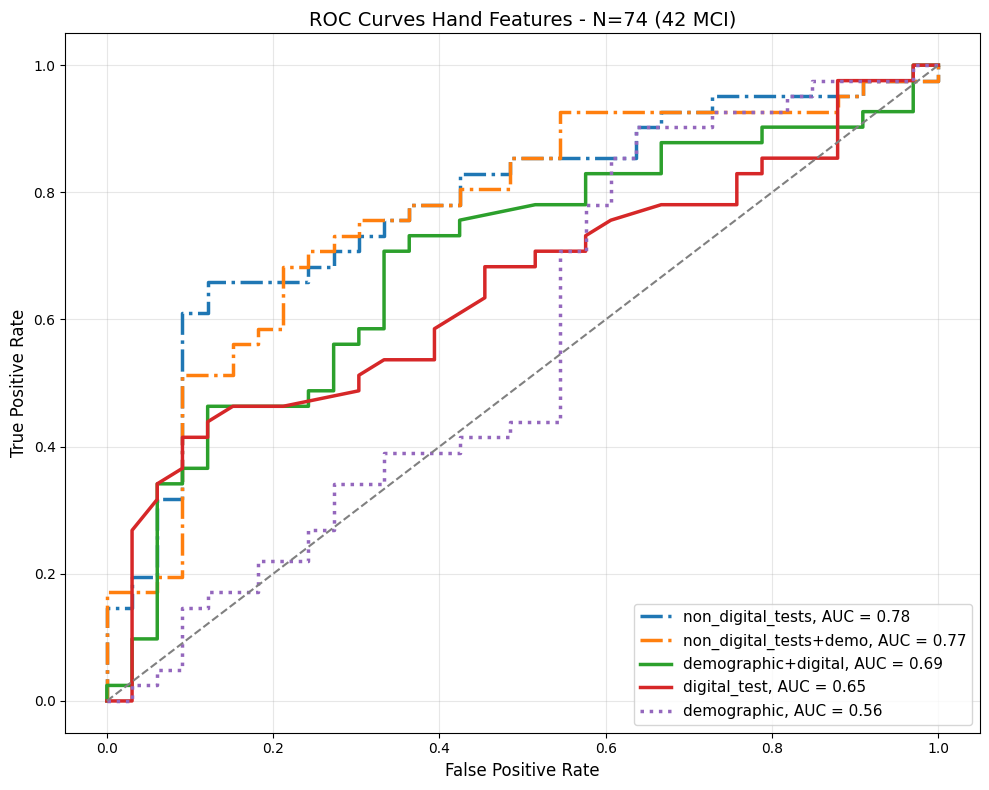

In [44]:
top1_per_dataset_complete = top1_per_dataset[top1_per_dataset['complete']]

colors = sns.color_palette("Set2", len(top1_per_dataset_complete))

# Define a style map based on dataset types
style_map = {
    'non_digital_tests+demo': 'dashdot',
    'non_digital_tests': 'dashdot',
    'demographic+digital': 'solid',
    'digital_test': 'solid',
    'demographic': 'dotted'
}

print(colors)
plt.figure(figsize=(10, 8))

for idx, row in top1_per_dataset_complete.iterrows():
    y_true = row['y_true']
    y_pred_proba = row['y_pred_proba']

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Get style based on dataset name
    linestyle = style_map.get(row['base_dataset'], 'solid')

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2.5,
            #  color=colors[idx],
             linestyle=linestyle,
             label=f"{row['base_dataset']}, AUC = {round(roc_auc, 2)}")

# Diagonal
plt.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')

# Titles and labels
plt.title("ROC Curves Hand Features - N=74 (42 MCI)", fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


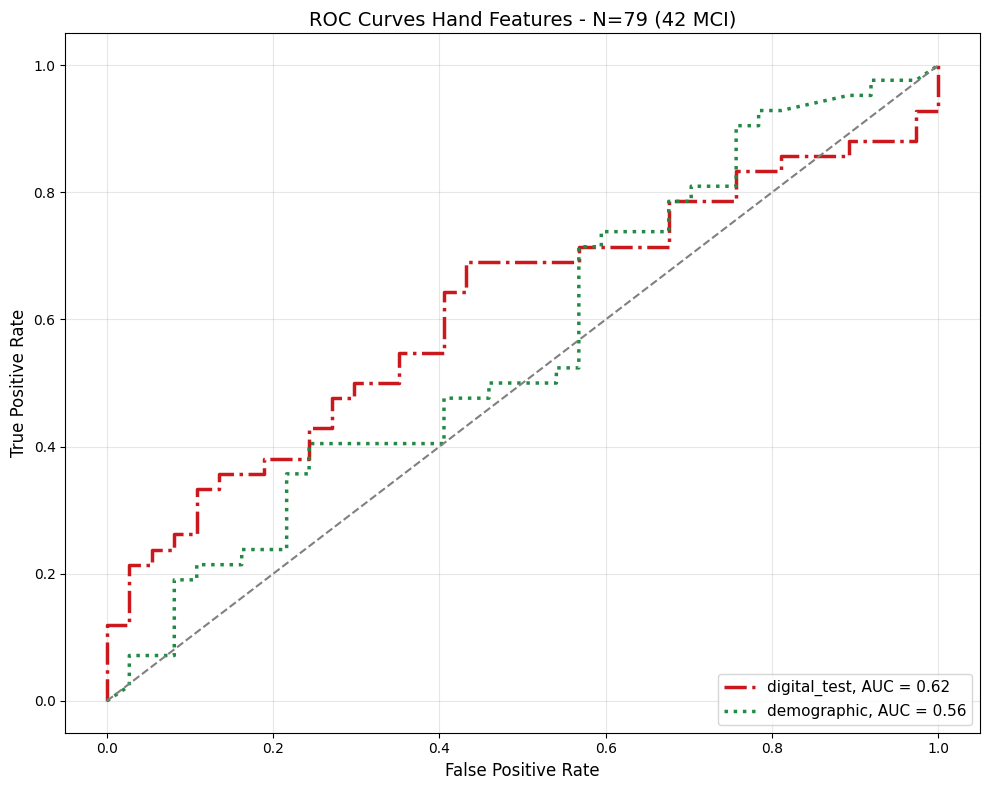

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

top1_per_dataset_complete = top1_per_dataset[top1_per_dataset['complete']]


# Define groups
group_map = {
    'non_digital_tests': 'non_digital',
    'non_digital_tests+demo': 'non_digital',
    'demographic': 'demographic',
    'demographic+digital': 'digital',
    'digital_test': 'digital'
}

# Define line styles per group
group_linestyles = {
    'non_digital': 'solid',
    'demographic': 'dotted',
    'digital': 'dashdot'
}

# Assign a color palette per group
group_palettes = {
    'non_digital': sns.color_palette("Blues", n_colors=3),
    'demographic': sns.color_palette("Greens", n_colors=3),
    'digital': sns.color_palette("Reds", n_colors=3)
}

# Track color usage per group
group_color_index = {
    'non_digital': 20,
    'demographic': 20,
    'digital': 20
}

plt.figure(figsize=(10, 8))

for idx, row in top1_per_dataset_complete.iterrows():
    y_true = row['y_true']
    y_pred_proba = row['y_pred_proba']
    dataset = row['base_dataset']
    
    # Assign group
    group = group_map[dataset]
    
    # Assign color and linestyle
    color_list = group_palettes[group]
    color_idx = group_color_index[group]
    color = color_list[color_idx % len(color_list)]
    group_color_index[group] += 1
    
    linestyle = group_linestyles[group]
    
    # Compute ROC and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, lw=2.5,
             color=color,
             linestyle=linestyle,
             label=f"{dataset}, AUC = {round(roc_auc, 2)}")

# Diagonal
plt.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')

# Titles and labels
plt.title("ROC Curves Hand Features - N=79 (42 MCI)", fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [45]:
# Option 1: Ensure exact count
def permutation_test_auc(y_true, y_pred_proba, n_permutations=1000, seed=42):
    rng = np.random.RandomState(seed)
    true_auc = roc_auc_score(y_true, y_pred_proba)
    
    permuted_aucs = []
    attempts = 0
    max_attempts = n_permutations * 10  # Prevent infinite loop
    
    while len(permuted_aucs) < n_permutations and attempts < max_attempts:
        y_permuted = rng.permutation(y_true)
        try:
            perm_auc = roc_auc_score(y_permuted, y_pred_proba)
            permuted_aucs.append(perm_auc)
        except ValueError:
            pass  # Skip failed permutations
        attempts += 1
    
    if len(permuted_aucs) < n_permutations:
        print(f"Warning: Only {len(permuted_aucs)} valid permutations out of {n_permutations}")
    
    p_value = (np.sum(np.array(permuted_aucs) >= true_auc) + 1) / (len(permuted_aucs) + 1)
    return true_auc, p_value

for idx, row in top1_per_dataset[top1_per_dataset['complete']].iterrows():
    y_true = np.array(row['y_true'])
    y_proba = np.array(row['y_pred_proba'])

    auc, p_val = permutation_test_auc(y_true, y_proba, n_permutations=1000)
    print(f"{row['model']} on {row['base_dataset']} → AUC = {auc:.3f}, p = {p_val:.4f}")


LogisticRegression on non_digital_tests → AUC = 0.778, p = 0.0010
LogisticRegression on non_digital_tests+demo → AUC = 0.766, p = 0.0010
SVC on demographic+digital → AUC = 0.691, p = 0.0030
RandomForestClassifier on digital_test → AUC = 0.649, p = 0.0180
XGBClassifier on demographic → AUC = 0.561, p = 0.1808


In [14]:
top1_per_dataset[~top1_per_dataset['complete']].reset_index(drop=True)

,model,auc,accuracy,balanced_accuracy,precision,recall,f1,y_true,y_pred_proba,dataset,PCA,features,complete,base_dataset
0,LogisticRegression,0.861538,0.785714,0.784615,0.800000,0.800000,0.800000,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.7836578964053217, 0.9635695616255298, 0.249...",non_digital_test_less_subjects+demo_feature_Tr...,True,True,False,non_digital_test_less_subjects+demo
1,LogisticRegression,0.852564,0.767857,0.767949,0.793103,0.766667,0.779661,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.748883882649633, 0.9622343704431096, 0.3376...",non_digital_test_less_subjects_feature_True_n=...,True,True,False,non_digital_test_less_subjects
2,XGBClassifier,0.826823,0.732143,0.729167,0.774194,0.750000,0.761905,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0364810936152935, 0.7592764496803284, 0.977...",demographic+digital_less_feature_True_n=20_tun...,False,True,False,demographic+digital_less
3,SVC,0.712240,0.696429,0.666667,0.682927,0.875000,0.767123,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.3694907968346878, 0.6524316530913943, 0.537...",demographic_less_subjects_feature_True_n=3_tun...,False,True,False,demographic_less_subjects
4,RandomForestClassifier,0.592949,0.589286,0.585897,0.612903,0.633333,0.622951,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.27, 0.87, 0.55, 0.89, 0.65, 0.92, 0.23, 0.4...",hand_and_eye_demo_feature_True_n=20_tune=False,True,True,False,hand_and_eye_demo
5,LogisticRegression,0.530769,0.500000,0.497436,0.533333,0.533333,0.533333,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.284397643654871, 0.839603343565816, 0.22497...",hand_and_eye_feature_True_n=20_tune=False,True,True,False,hand_and_eye
6,XGBClassifier,0.511538,0.535714,0.533333,0.566667,0.566667,0.566667,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.6866195201873779, 0.2701362371444702, 0.970...",digital_test_less_subjects_feature_True_n=20_t...,True,True,False,digital_test_less_subjects


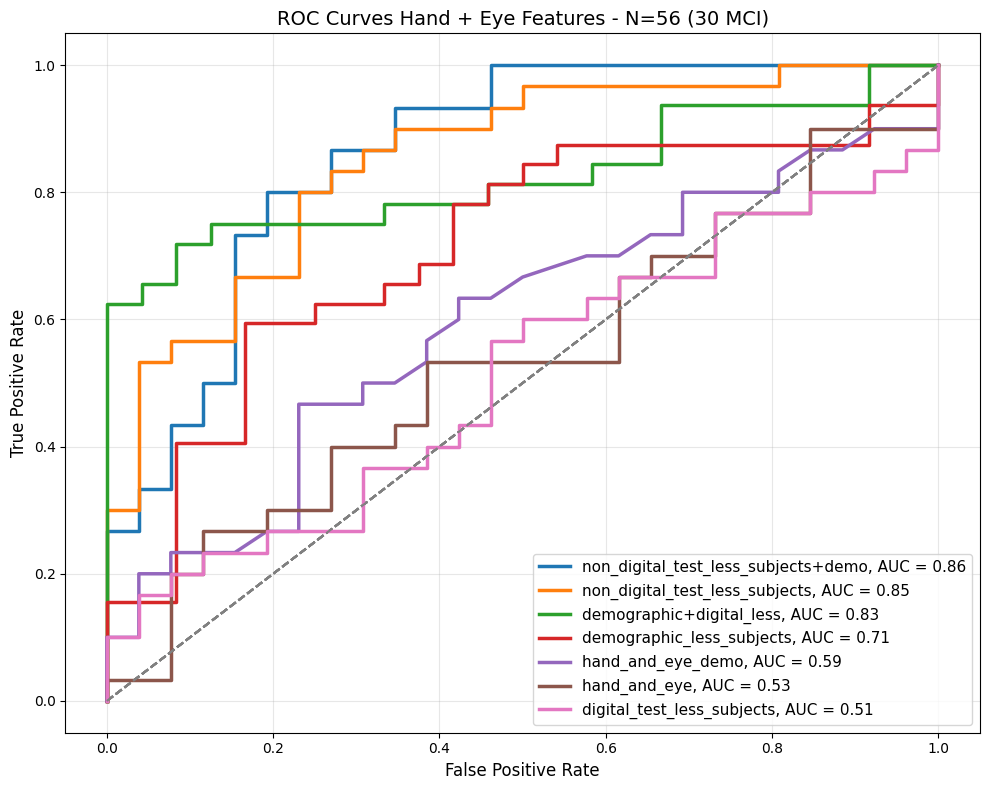

In [26]:
top1_per_dataset_incomplete = top1_per_dataset[~top1_per_dataset['complete']]

colors = sns.color_palette("Set2", len(top1_per_dataset_incomplete))

plt.figure(figsize=(10, 8))


for idx, row in top1_per_dataset_incomplete.iterrows():
    y_true = row['y_true']
    y_pred_proba = row['y_pred_proba']
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot settings
    plt.plot(fpr, tpr, lw=2.5,
             label=f"{row['base_dataset']}, AUC = {round(roc_auc,2)}")
    
    plt.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')

    # Titles and labels
    plt.title("ROC Curves Hand + Eye Features - N=56 (30 MCI)",
              fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(alpha=0.3)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()


In [56]:
top1_per_dataset_incomplete = top1_per_dataset[~top1_per_dataset['complete']]

for idx, row in top1_per_dataset_incomplete.iterrows():
    y_true = np.array(row['y_true'])
    y_proba = np.array(row['y_pred_proba'])

    auc, p_val = permutation_test_auc(y_true, y_proba, n_permutations=1000)
    print(f"{row['model']} on {row['base_dataset']} → AUC = {auc:.3f}, p = {p_val:.4f}")

LogisticRegression on non_digital_test_less_subjects+demo → AUC = 0.862, p = 0.0010
LogisticRegression on non_digital_test_less_subjects → AUC = 0.853, p = 0.0010
XGBClassifier on demographic+digital_less → AUC = 0.827, p = 0.0010
SVC on demographic_less_subjects → AUC = 0.712, p = 0.0030
RandomForestClassifier on hand_and_eye_demo → AUC = 0.593, p = 0.0949
LogisticRegression on hand_and_eye → AUC = 0.531, p = 0.3317
XGBClassifier on digital_test_less_subjects → AUC = 0.512, p = 0.4296


# Regression

In [6]:
# Import necessary libraries
import os
import logging
import traceback
import numpy as np
import pandas as pd
from datetime import datetime

# Scikit-learn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import (
    GridSearchCV, 
    KFold, 
    RepeatedKFold, 
    LeaveOneOut, 
    StratifiedKFold
)
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    explained_variance_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA

# XGBoost
import xgboost as xgb

In [9]:
# # Configure logging
# # Ensure logs folder exists
# log_dir = "logs"
# os.makedirs(log_dir, exist_ok=True)
# # Create a fresh log file each run
# log_filename = os.path.join(log_dir, f"error_log_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.log")
# logging.basicConfig(filename=log_filename,
#                     level=logging.ERROR,
#                     format='%(asctime)s - %(levelname)s - %(message)s')


# # ───────────────────────────────────────────────────────────────
# # 0. SET-UP GENERAL 
# # ───────────────────────────────────────────────────────────────
# df_metadata_for_ml = pd.read_csv("metadata_for_ml.csv")
# df_y = df_metadata_for_ml[['suj', 'mmse']]

# n_splits = 2
# n_repeats = 1

# global_seed = 42
# inner_cv_seed = 50  # Fixed for reproducibility in inner CV
# perform_pca = False
# type_of_csv = 'loo'
# n_components = 4
# tune_hyperparameters = False
# feature_selection = True

# # datasets = [
# #             # N=79
# #             'demographic', 
# #             'digital_test', 
# #             'demographic+digital',
# #             'non_digital_tests', 
# #             'non_digital_tests+demo',

# #             # N=56
# #             'demographic_less_subjects', 
# #             'digital_test_less_subjects', 
# #             'demographic+digital_less',
# #             'hand_and_eye',
# #             'hand_and_eye_demo',
# #             'non_digital_test_less_subjects', 
# #             'non_digital_test_less_subjects+demo'
# #             ]

# datasets = ['non_digital_test_less_subjects+demo']


# def extract_X_y_features_regression(df, metadata):
#     df = df.merge(metadata, how='inner', on='suj')
#     df = df.drop(['suj', 'group'], axis=1)
#     print("group in X", 'group' in df.iloc[:, :-1].columns)
#     print("suj in X", 'suj' in df.iloc[:, :-1].columns)
#     display(df.head(2))
#     X = df.iloc[:, :-1].values
#     y = df.iloc[:, -1].values
#     feature_names = df.columns[:-1]
    
#     return X, y, feature_names 

# def join_and_reorder_regression(df1, df2):
#     df = df1.join(df2.drop(columns='group'))
#     cols = [col for col in df.columns if col != 'group'] + ['group']
#     df = df[cols]
#     assert df.columns[-1] == 'group', "'group' is not the last column after reordering"
#     return df

# y_variable = 'mmse'
# df_y = df_metadata_for_ml[['suj',y_variable]]

# for value in [True, False]: 
#     perform_pca = value
#     for dataset in datasets:
#         try:
#             print(f"Starting {dataset}: \n\n")
#             if perform_pca:
#                 print("Performing PCA")

#             match dataset:
#                 case 'demographic':
#                     X, y, feature_names = extract_X_y_features_regression(demographic_df, df_y)

#                 case 'demographic_less_subjects':  
#                     df = demographic_df.loc[df_digital_hand_and_eye.index]
#                     X, y, feature_names = extract_X_y_features_regression(df, df_y)

#                 case 'demographic+digital':
#                     df = join_and_reorder_regression(df_digital_tmt_with_target, demographic_df)
#                     X, y, feature_names = extract_X_y_features_regression(df, df_y)

#                 case 'demographic+digital_less':
#                     df = join_and_reorder_regression(df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index], demographic_df)
#                     X, y, feature_names = extract_X_y_features_regression(df, df_y)

#                 case 'non_digital_tests':
#                     non_digital_df = non_digital_df.drop(y_variable, axis=1)
#                     X, y, feature_names = extract_X_y_features_regression(non_digital_df, df_y)

#                 case 'non_digital_tests+demo':
#                     df = join_and_reorder_regression(non_digital_df.drop(columns=['suj', y_variable]), demographic_df)
#                     X, y, feature_names = extract_X_y_features_regression(df, df_y)

#                 case 'non_digital_test_less_subjects':
#                     X, y, feature_names = extract_X_y_features_regression(non_digital_test_less_subjects, df_y)

#                 case 'non_digital_test_less_subjects+demo':
#                     non_digital_test_less_subjects = non_digital_test_less_subjects.drop(y_variable, axis=1)
#                     df = join_and_reorder_regression(non_digital_test_less_subjects.drop(columns='suj'), demographic_df)
#                     X, y, feature_names = extract_X_y_features_regression(df, df_y)

#                 case 'digital_test':
#                     X, y, feature_names = extract_X_y_features_regression(df_digital_tmt_with_target, df_y)

#                 case 'digital_test_less_subjects':
#                     X, y, feature_names = extract_X_y_features_regression(digital_test_less_subjects, df_y)

#                 case 'hand_and_eye':
#                     X, y, feature_names = extract_X_y_features_regression(df_digital_hand_and_eye, df_y)

#                 case 'hand_and_eye_demo':
#                     df = join_and_reorder_regression(df_digital_hand_and_eye, demographic_df)
#                     X, y, feature_names = extract_X_y_features_regression(df, df_y)

#                 case _:
#                     raise ValueError(f'Please select a valid dataset from: {datasets}')


#             # ───────────────────────────────────────────────────────────────
#             # 1. DEFINICIÓN DE PARÁMETROS Y MODELOS 
#             # ───────────────────────────────────────────────────────────────

#             unique, counts = np.unique(y, return_counts=True)
#             print("Class distribution:", dict(zip(unique, counts)))

#             # Define parameter grids
#             param_grids = {
#                 "RandomForestClassifier": {
#                     "classifier__n_estimators": [100, 500, 700, 1000],
#                     "classifier__max_depth": [None, 10, 20, 30]
#                 },
#                 "SVC": {
#                     "classifier__C": [0.1, 1, 10],
#                     "classifier__kernel": ['linear', 'rbf']
#                 },
#                 "LogisticRegression": {
#                     "classifier__C": [0.1, 1, 10],
#                     "classifier__penalty": ['l2']
#                 },
#                 "XGBClassifier": {
#                     "classifier__n_estimators": [100, 300],
#                     "classifier__max_depth": [3, 5],
#                     "classifier__learning_rate": [0.05, 0.1]
#                 }
#             }

#             # Define models to evaluate
#             models = [
#                 # RandomForestClassifier(random_state=42, n_jobs=-1),
#                 # SVC(random_state=42, probability=True),
#                 LogisticRegression(max_iter=1000, random_state=42, solver='saga', n_jobs=-1),
#                 # xgb.XGBClassifier(random_state=42, tree_method="hist", eval_metric='logloss',n_jobs=-1)
#             ]

#             # ───────────────────────────────────────────────────────────────
#             # 2. Cross validation
#             # ───────────────────────────────────────────────────────────────

#             match type_of_csv:
#                 case 'stratified':
#                     print(f"RepeatedStratifiedKFold selected with n_splits = {n_splits} and n_repeats = {n_repeats}")
#                     outer_cv = RepeatedStratifiedKFold(
#                         n_splits=n_splits,
#                         n_repeats=n_repeats,         
#                         random_state=global_seed # Global seed
#                     )
#                 case 'loo':
#                     print("LeaveOneOut selected")
#                     outer_cv = LeaveOneOut()
#                 case _:
#                     print("select a valid CV type")

#             mean_fpr = np.linspace(0, 1, 100)
#             all_metrics_df = pd.DataFrame(columns=[
#                 'model', 'repeat', 'fold',   
#                 'accuracy', 'balanced_accuracy', 'precision', 
#                 'recall', 'f1', 'auc', 'specificity'
#             ])

#             # ───────────────────────────────────────────────────────────────
#             # 3. External loop 
#             # ───────────────────────────────────────────────────────────────
#             for model in models:
#                 model_name = model.__class__.__name__
#                 print(f"\n🧪 CV for: {model_name}")

#                 tprs, aucs, best_params_list, fold_metrics = [], [], [], []
#                 feature_importance_counts = {n: 0 for n in feature_names}

#                 # fig, ax = plt.subplots(figsize=(6, 6))
#                 all_y_true, all_y_pred = [], []

#                 # Enumeramos 'repeat' y 'fold' para guardar en métricas
#                 for outer_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
#                     n_features = 20
#                     n_components = 4
#                     fold = outer_idx  # index of the left-out observation
#                     print('fold:', fold)

#                     # ── Split
#                     X_train, X_test = X[train_idx], X[test_idx]
#                     y_train, y_test = y[train_idx], y[test_idx]

                    
#                     # ── Inner CV: estratificado 3-fold con la MISMA semilla por repetición
#                     inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=inner_cv_seed)
                    
#                     if perform_pca:
#                         n_components = min(n_components, X_train.shape[1])
#                         print("n_components:", n_components)
#                         pca_step = ('pca', PCA(n_components=n_components))
#                     else:
#                         pca_step = ('noop', 'passthrough')

                    
#                     if feature_selection:
#                         n_features = min(n_features, X_train.shape[1])
#                         print("n_features:", n_features)
#                         feature_selection_step = ('select', SelectKBest(score_func=f_classif, k=n_features))
#                     else:
#                         feature_selection_step = ('noop', 'passthrough')

#                     pipeline = Pipeline([
#                         ('imputer', SimpleImputer(strategy='mean')),  # or 'median' depending on your data
#                         feature_selection_step,
#                         ('scaler', StandardScaler()),
#                         pca_step,
#                         ('classifier', model)
#                     ])

#                     # Hiperparámetros
#                     param_grid = param_grids.get(model_name, {})


#                     if tune_hyperparameters and param_grid:
#                         grid = GridSearchCV(
#                             pipeline,
#                             param_grid=param_grid,
#                             cv=inner_cv,               
#                             scoring='roc_auc',
#                             n_jobs=-1,
#                             verbose=0
#                         )
#                         grid.fit(X_train, y_train)
#                         best_model = grid.best_estimator_
#                         best_params_list.append(grid.best_params_)
#                     else:
#                         pipeline.fit(X_train, y_train)
#                         best_model = pipeline
#                         best_params_list.append("no tuning")

#                     # ── Predicción
#                     y_pred_proba = best_model.predict_proba(X_test)[:, 1]
#                     y_pred = best_model.predict(X_test)

#                     all_y_true.extend(y_test)
#                     all_y_pred.extend(y_pred)

#                     fold_metrics.append({
#                         'model': model_name,
#                         'fold': fold,              
#                         'y_test': y_test[0],
#                         'y_pred': y_pred[0],
#                         'y_pred_proba': y_pred_proba[0],
#                         'feature_names': feature_names.values
#                     })

#                 # ── Guardamos métricas
#                 all_metrics_df = pd.concat([all_metrics_df,
#                                             pd.DataFrame(fold_metrics)],
#                                         ignore_index=True)


#             # save
#             dir = f'./results/modelling/regression/{datetime.now().strftime("%Y-%m-%d")}'
#             os.makedirs(dir, exist_ok=True)
#             if perform_pca:
#                 all_metrics_df.to_csv(f'{dir}/{dataset}_feature_{feature_selection}_n={n_features}_tune={tune_hyperparameters}_LOOCV_PCA_n_components{n_components}_{datetime.now().strftime("%s")[-4:]}.csv',index=False)
#             else:
#                 all_metrics_df.to_csv(f'{dir}/{dataset}_feature_{feature_selection}_n={n_features}_tune={tune_hyperparameters}_LOOCV_{datetime.now().strftime("%s")[-4:]}.csv',index=False)
#         except Exception as e:
#             print(e)
#             error_msg = traceback.format_exc().strip().split("\n")[-1]  # only last line of error
#             logging.error(f"[{dataset}] PCA={perform_pca} → {error_msg}")
#             print(f"⚠️ An error occurred with dataset {dataset}. Check log file: {log_filename}")


In [ ]:
# Configure logging
# Ensure logs folder exists
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
# Create a fresh log file each run
log_filename = os.path.join(log_dir, f"error_log_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.log")
logging.basicConfig(filename=log_filename,
                    level=logging.ERROR,
                    format='%(asctime)s - %(levelname)s - %(message)s')


# ───────────────────────────────────────────────────────────────
# 0. SET-UP GENERAL 
# ───────────────────────────────────────────────────────────────
n_splits = 2
n_repeats = 1

global_seed = 42
inner_cv_seed = 50  # Fixed for reproducibility in inner CV
perform_pca = False
type_of_csv = 'loo'
n_components = 4
tune_hyperparameters = False
feature_selection = True

datasets = [
            # N=79
            'demographic', 
            'digital_test', 
            'demographic+digital',
            'non_digital_tests', 
            'non_digital_tests+demo',

            # N=56
            'demographic_less_subjects', 
            'digital_test_less_subjects', 
            'demographic+digital_less',
            'hand_and_eye',
            'hand_and_eye_demo',
            'non_digital_test_less_subjects', 
            'non_digital_test_less_subjects+demo'
            ]

datasets = ['non_digital_test_less_subjects+demo']


def extract_X_y_features_regression(df, metadata):
    if metadata.columns[-1] not in df.columns:
        df = df.merge(metadata, how='inner', on='suj')

    df = df.drop(['suj', 'group'], axis=1)
    print("group in X", 'group' in df.iloc[:, :-1].columns)
    print("suj in X", 'suj' in df.iloc[:, :-1].columns)
    display(df.head(2))
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    feature_names = df.columns[:-1]
    
    return X, y, feature_names 

def join_and_reorder_regression(df1, df2):
    df = df1.join(df2.drop(columns='group'))
    cols = [col for col in df.columns if col != 'group'] + ['group']
    df = df[cols]
    assert df.columns[-1] == 'group', "'group' is not the last column after reordering"
    return df

target_variable = 'mmse'
df_y = df_metadata_for_ml[['suj',target_variable]]

for value in [True, False]: 
    perform_pca = value
    for dataset in datasets:
        try:
            print(f"Starting {dataset}: \n\n")
            if perform_pca:
                print("Performing PCA")

            match dataset:
                case 'demographic':
                    X, y, feature_names = extract_X_y_features_regression(demographic_df, df_y)

                case 'demographic_less_subjects':  
                    df = demographic_df.loc[df_digital_hand_and_eye.index]
                    X, y, feature_names = extract_X_y_features_regression(df, df_y)

                case 'demographic+digital':
                    df = join_and_reorder_regression(df_digital_tmt_with_target, demographic_df)
                    X, y, feature_names = extract_X_y_features_regression(df, df_y)

                case 'demographic+digital_less':
                    df = join_and_reorder_regression(df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index], demographic_df)
                    X, y, feature_names = extract_X_y_features_regression(df, df_y)

                case 'non_digital_tests':
                    # non_digital_df = non_digital_df.drop(target_variable, axis=1)
                    X, y, feature_names = extract_X_y_features_regression(non_digital_df, df_y)

                case 'non_digital_tests+demo':
                    df = join_and_reorder_regression(non_digital_df.drop(columns=['suj', target_variable]), demographic_df)
                    X, y, feature_names = extract_X_y_features_regression(df, df_y)

                case 'non_digital_test_less_subjects':
                    X, y, feature_names = extract_X_y_features_regression(non_digital_test_less_subjects, df_y)

                case 'non_digital_test_less_subjects+demo':
                    # non_digital_test_less_subjects = non_digital_test_less_subjects.drop(target_variable, axis=1)
                    df = join_and_reorder_regression(non_digital_test_less_subjects.drop(columns='suj'), demographic_df)
                    X, y, feature_names = extract_X_y_features_regression(df, df_y)

                case 'digital_test':
                    X, y, feature_names = extract_X_y_features_regression(df_digital_tmt_with_target, df_y)

                case 'digital_test_less_subjects':
                    X, y, feature_names = extract_X_y_features_regression(digital_test_less_subjects, df_y)

                case 'hand_and_eye':
                    X, y, feature_names = extract_X_y_features_regression(df_digital_hand_and_eye, df_y)

                case 'hand_and_eye_demo':
                    df = join_and_reorder_regression(df_digital_hand_and_eye, demographic_df)
                    X, y, feature_names = extract_X_y_features_regression(df, df_y)

                case _:
                    raise ValueError(f'Please select a valid dataset from: {datasets}')


                # ───────────────────────────────────────────────────────────────
            # 1. DEFINICIÓN DE PARÁMETROS Y MODELOS 
            # ───────────────────────────────────────────────────────────────

            # Display target variable statistics
            print(f"Target variable statistics for {target_variable}:")
            print(f"  Mean: {np.mean(y):.3f}")
            print(f"  Std: {np.std(y):.3f}")
            print(f"  Min: {np.min(y):.3f}")
            print(f"  Max: {np.max(y):.3f}")
            print(f"  Valid samples: {len(y)}")

            # Define parameter grids for regression models
            param_grids = {
                "RandomForestRegressor": {
                    "regressor__n_estimators": [100, 500, 700, 1000],
                    "regressor__max_depth": [None, 10, 20, 30]
                },
                "SVR": {
                    "regressor__C": [0.1, 1, 10],
                    "regressor__kernel": ['linear', 'rbf'],
                    "regressor__epsilon": [0.01, 0.1, 0.2]
                },
                "LinearRegression": {
                    # LinearRegression has no hyperparameters to tune
                },
                "Ridge": {
                    "regressor__alpha": [0.1, 1.0, 10.0, 100.0]
                },
                "Lasso": {
                    "regressor__alpha": [0.01, 0.1, 1.0, 10.0]
                },
                "XGBRegressor": {
                    "regressor__n_estimators": [100, 300],
                    "regressor__max_depth": [3, 5],
                    "regressor__learning_rate": [0.05, 0.1]
                }
            }

            # Define regression models to evaluate
            models = [
                RandomForestRegressor(random_state=42, n_jobs=-1),
                SVR(),
                LinearRegression(n_jobs=-1),
                Ridge(random_state=42),
                Lasso(random_state=42),
                xgb.XGBRegressor(random_state=42, tree_method="hist", n_jobs=-1)
            ]

            # ───────────────────────────────────────────────────────────────
            # 2. Cross validation
            # ───────────────────────────────────────────────────────────────

            match type_of_csv:
                case 'kfold':
                    print(f"RepeatedKFold selected with n_splits = {n_splits} and n_repeats = {n_repeats}")
                    outer_cv = RepeatedKFold(
                        n_splits=n_splits,
                        n_repeats=n_repeats,         
                        random_state=global_seed # Global seed
                    )
                case 'loo':
                    print("LeaveOneOut selected")
                    outer_cv = LeaveOneOut()
                case _:
                    print("select a valid CV type (kfold or loo)")

            all_metrics_df = pd.DataFrame(columns=[
                'dataset', 'target_column', 'model', 'repeat', 'fold',   
                'mse', 'rmse', 'mae', 'r2', 'explained_variance'
            ])

            # ───────────────────────────────────────────────────────────────
            # 3. External loop 
            # ───────────────────────────────────────────────────────────────
            for model in models:
                model_name = model.__class__.__name__
                print(f"\n🧪 CV for: {model_name}")

                best_params_list, fold_metrics = [], []
                feature_importance_counts = {n: 0 for n in feature_names}

                all_y_true, all_y_pred = [], []

                # Enumeramos 'repeat' y 'fold' para guardar en métricas
                for outer_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
                    n_features = min(20, X.shape[1])  # Ensure we don't exceed available features
                    n_components_actual = min(n_components, X.shape[1])
                    fold = outer_idx  # index of the left-out observation
                    print(f'fold: {fold}')

                    # ── Split
                    X_train, X_test = X[train_idx], X[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]

                    
                    # ── Inner CV: regular KFold for regression (no stratification needed)
                    inner_cv = KFold(n_splits=min(3, len(y_train)), shuffle=True, random_state=inner_cv_seed)
                    
                    if perform_pca:
                        print("n_components:", n_components_actual)
                        pca_step = ('pca', PCA(n_components=n_components_actual))
                    else:
                        pca_step = ('noop', 'passthrough')

                    
                    if feature_selection:
                        print("n_features:", n_features)
                        # Use f_regression for regression feature selection
                        feature_selection_step = ('select', SelectKBest(score_func=f_regression, k=n_features))
                    else:
                        feature_selection_step = ('noop', 'passthrough')

                    pipeline = Pipeline([
                        ('imputer', SimpleImputer(strategy='mean')),  # or 'median' depending on your data
                        feature_selection_step,
                        ('scaler', StandardScaler()),
                        pca_step,
                        ('regressor', model)  # Changed from 'classifier' to 'regressor'
                    ])

                    # Hiperparámetros
                    param_grid = param_grids.get(model_name, {})

                    if tune_hyperparameters and param_grid:
                        grid = GridSearchCV(
                            pipeline,
                            param_grid=param_grid,
                            cv=inner_cv,               
                            scoring='neg_mean_squared_error',  # Changed from 'roc_auc' to regression metric
                            n_jobs=-1,
                            verbose=0
                        )
                        grid.fit(X_train, y_train)
                        best_model = grid.best_estimator_
                        best_params_list.append(grid.best_params_)
                    else:
                        pipeline.fit(X_train, y_train)
                        best_model = pipeline
                        best_params_list.append("no tuning")

                    # ── Prediction (no probability prediction for regression)
                    y_pred = best_model.predict(X_test)

                    all_y_true.extend(y_test)
                    all_y_pred.extend(y_pred)

                    # Calculate regression metrics
                    mse = mean_squared_error(y_test, y_pred)
                    rmse = np.sqrt(mse)
                    mae = mean_absolute_error(y_test, y_pred)
                    r2 = r2_score(y_test, y_pred)
                    explained_var = explained_variance_score(y_test, y_pred)

                    fold_metrics.append({
                        'dataset': dataset,
                        'target_column': target_variable,
                        'model': model_name,
                        'fold': fold,              
                        'y_test': y_test[0] if len(y_test) == 1 else y_test,
                        'y_pred': y_pred[0] if len(y_pred) == 1 else y_pred,
                        'mse': mse,
                        'rmse': rmse,
                        'mae': mae,
                        'r2': r2,
                        'explained_variance': explained_var,
                        'feature_names': feature_names.values
                    })

                # ── Guardamos métricas
                all_metrics_df = pd.concat([all_metrics_df,
                                            pd.DataFrame(fold_metrics)],
                                        ignore_index=True)

                # Print overall performance for this model
                if len(all_y_true) > 0:
                    overall_mse = mean_squared_error(all_y_true, all_y_pred)
                    overall_r2 = r2_score(all_y_true, all_y_pred)
                    print(f"Overall MSE: {overall_mse:.4f}, R²: {overall_r2:.4f}")

        # save
            dir = f'./results/modelling/regression/{datetime.now().strftime("%Y-%m-%d")}'
            os.makedirs(dir, exist_ok=True)
            if perform_pca:
                all_metrics_df.to_csv(f'{dir}/{dataset}_feature_{feature_selection}_n={n_features}_tune={tune_hyperparameters}_LOOCV_PCA_n_components{n_components}_{datetime.now().strftime("%s")[-4:]}.csv',index=False)
            else:
                all_metrics_df.to_csv(f'{dir}/{dataset}_feature_{feature_selection}_n={n_features}_tune={tune_hyperparameters}_LOOCV_{datetime.now().strftime("%s")[-4:]}.csv',index=False)
        except Exception as e:
            print(e)
            error_msg = traceback.format_exc().strip().split("\n")[-1]  # only last line of error
            logging.error(f"[{dataset}] PCA={perform_pca} → {error_msg}")
            print(f"⚠️ An error occurred with dataset {dataset}. Check log file: {log_filename}")



Starting non_digital_test_less_subjects+demo: 


Performing PCA
group in X False
suj in X False


,tmt_a_raw,tmt_a_z,tmt_b_raw,tmt_b_z,digit_symbol_raw,digit_symbol_z,forward_digit_span_raw,forward_digit_span_z,backward_digit_span_raw,backward_digit_span_z,clock_drawing_test,sex,age,years_of_education,mmse
0,65.0,-0.38,107.00,0.40,45.0,0.33,5.0,0.64,4.0,0.21,3.0,1,52,18.0,30.0
1,63.0,-0.29,180.09,-0.92,32.0,0.00,5.0,-0.64,3.0,-0.93,1.0,0,78,16.0,28.0


Target variable statistics for mmse:
  Mean: 27.893
  Std: 2.041
  Min: 22.000
  Max: 30.000
  Valid samples: 56
LeaveOneOut selected

🧪 CV for: RandomForestRegressor
fold: 0
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 1
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 2
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 3
n_components: 4
n_features: 14
fold: 4
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 5
n_components: 4
n_features: 14
fold: 6
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 7
n_components: 4
n_features: 14
fold: 8
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 9
n_components: 4
n_features: 14
fold: 10
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 11
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 12
n_components: 4
n_features: 14
fold: 13
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 14
n_components: 4
n_features: 14
fold: 15
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 16
n_components: 4
n_features: 14
fold: 17
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 18
n_components: 4
n_features: 14
fold: 19
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 20
n_components: 4
n_features: 14
fold: 21
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 22
n_components: 4
n_features: 14
fold: 23
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 24
n_components: 4
n_features: 14
fold: 25
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 26
n_components: 4
n_features: 14
fold: 27
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 28
n_components: 4
n_features: 14
fold: 29
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 30
n_components: 4
n_features: 14
fold: 31
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 32
n_components: 4
n_features: 14
fold: 33
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 34
n_components: 4
n_features: 14
fold: 35
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 36
n_components: 4
n_features: 14
fold: 37
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 38
n_components: 4
n_features: 14
fold: 39
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 40
n_components: 4
n_features: 14
fold: 41
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 42
n_components: 4
n_features: 14
fold: 43
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 44
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 45
n_components: 4
n_features: 14
fold: 46
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 47
n_components: 4
n_features: 14
fold: 48
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 49
n_components: 4
n_features: 14
fold: 50
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 51
n_components: 4
n_features: 14
fold: 52
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 53
n_components: 4
n_features: 14
fold: 54
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 55
n_components: 4
n_features: 14
Overall MSE: 4.0107, R²: 0.0375

🧪 CV for: SVR
fold: 0
n_components: 4
n_features: 14
fold: 1
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 2
n_components: 4
n_features: 14
fold: 3
n_components: 4
n_features: 14
fold: 4
n_components: 4
n_features: 14
fold: 5
n_components: 4
n_features: 14
fold: 6
n_components: 4
n_features: 14
fold: 7
n_components: 4
n_features: 14
fold: 8
n_components: 4
n_features: 14
fold: 9
n_components: 4
n_features: 14
fold: 10
n_components: 4
n_features: 14
fold: 11
n_components: 4
n_features: 14
fold: 12
n_components: 4
n_features: 14
fold: 13
n_components: 4
n_features: 14
fold: 14
n_components: 4
n_features: 14
fold: 15
n_components: 4
n_features: 14
fold: 16
n_components: 4
n_features: 14
fold: 17
n_components: 4
n_features: 14
fold: 18
n_components: 4
n_features: 14
fold: 19
n_components: 4
n_features: 14
fold: 20
n_components: 4
n_features: 14
fold: 21
n_components: 4
n_features: 14
fold: 22
n_components: 4
n_features: 14
fold: 23
n_components: 4
n_features: 14
fold: 24
n_components: 4
n_features: 14
fold: 25
n_components: 4
n_features: 14
fold: 26
n_components: 4
n_features: 14
fold: 27

/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 33
n_components: 4
n_features: 14
fold: 34
n_components: 4
n_features: 14
fold: 35
n_components: 4
n_features: 14
fold: 36
n_components: 4
n_features: 14
fold: 37
n_components: 4
n_features: 14
fold: 38
n_components: 4
n_features: 14
fold: 39
n_components: 4
n_features: 14
fold: 40
n_components: 4
n_features: 14
fold: 41
n_components: 4
n_features: 14
fold: 42
n_components: 4
n_features: 14
fold: 43
n_components: 4
n_features: 14
fold: 44
n_components: 4
n_features: 14
fold: 45
n_components: 4
n_features: 14
fold: 46
n_components: 4
n_features: 14
fold: 47
n_components: 4
n_features: 14
fold: 48
n_components: 4
n_features: 14
fold: 49
n_components: 4
n_features: 14
fold: 50
n_components: 4
n_features: 14
fold: 51
n_components: 4
n_features: 14
fold: 52
n_components: 4
n_features: 14
fold: 53
n_components: 4
n_features: 14
fold: 54
n_components: 4
n_features: 14
fold: 55
n_components: 4
n_features: 14
Overall MSE: 3.8370, R²: 0.0792

🧪 CV for: LinearRegression
fold: 0
n_components

/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 7
n_components: 4
n_features: 14
fold: 8
n_components: 4
n_features: 14
fold: 9
n_components: 4
n_features: 14
fold: 10
n_components: 4
n_features: 14
fold: 11
n_components: 4
n_features: 14
fold: 12
n_components: 4
n_features: 14
fold: 13
n_components: 4
n_features: 14
fold: 14
n_components: 4
n_features: 14
fold: 15
n_components: 4
n_features: 14
fold: 16
n_components: 4
n_features: 14
fold: 17
n_components: 4
n_features: 14
fold: 18
n_components: 4
n_features: 14
fold: 19
n_components: 4
n_features: 14
fold: 20
n_components: 4
n_features: 14
fold: 21
n_components: 4
n_features: 14
fold: 22
n_components: 4
n_features: 14
fold: 23
n_components: 4
n_features: 14
fold: 24
n_components: 4
n_features: 14
fold: 25
n_components: 4
n_features: 14
fold: 26
n_components: 4
n_features: 14
fold: 27
n_components: 4
n_features: 14
fold: 28
n_components: 4
n_features: 14
fold: 29
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 30
n_components: 4
n_features: 14
fold: 31
n_components: 4
n_features: 14
fold: 32
n_components: 4
n_features: 14
fold: 33
n_components: 4
n_features: 14
fold: 34
n_components: 4
n_features: 14
fold: 35
n_components: 4
n_features: 14
fold: 36
n_components: 4
n_features: 14
fold: 37
n_components: 4
n_features: 14
fold: 38
n_components: 4
n_features: 14
fold: 39
n_components: 4
n_features: 14
fold: 40
n_components: 4
n_features: 14
fold: 41
n_components: 4
n_features: 14
fold: 42
n_components: 4
n_features: 14
fold: 43
n_components: 4
n_features: 14
fold: 44
n_components: 4
n_features: 14
fold: 45
n_components: 4
n_features: 14
fold: 46
n_components: 4
n_features: 14
fold: 47
n_components: 4
n_features: 14
fold: 48
n_components: 4
n_features: 14
fold: 49
n_components: 4
n_features: 14
fold: 50
n_components: 4
n_features: 14
fold: 51
n_components: 4
n_features: 14
fold: 52
n_components: 4
n_features: 14
fold: 53
n_components: 4
n_features: 14
fold: 54
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 3
n_components: 4
n_features: 14
fold: 4
n_components: 4
n_features: 14
fold: 5
n_components: 4
n_features: 14
fold: 6
n_components: 4
n_features: 14
fold: 7
n_components: 4
n_features: 14
fold: 8
n_components: 4
n_features: 14
fold: 9
n_components: 4
n_features: 14
fold: 10
n_components: 4
n_features: 14
fold: 11
n_components: 4
n_features: 14
fold: 12
n_components: 4
n_features: 14
fold: 13
n_components: 4
n_features: 14
fold: 14
n_components: 4
n_features: 14
fold: 15
n_components: 4
n_features: 14
fold: 16
n_components: 4
n_features: 14
fold: 17
n_components: 4
n_features: 14
fold: 18
n_components: 4
n_features: 14
fold: 19
n_components: 4
n_features: 14
fold: 20
n_components: 4
n_features: 14
fold: 21
n_components: 4
n_features: 14
fold: 22
n_components: 4
n_features: 14
fold: 23
n_components: 4
n_features: 14
fold: 24
n_components: 4
n_features: 14
fold: 25
n_components: 4
n_features: 14
fold: 26
n_components: 4
n_features: 14
fold: 27
n_components: 4
n_features: 14
fold: 2

/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 34
n_components: 4
n_features: 14
fold: 35
n_components: 4
n_features: 14
fold: 36
n_components: 4
n_features: 14
fold: 37
n_components: 4
n_features: 14
fold: 38
n_components: 4
n_features: 14
fold: 39
n_components: 4
n_features: 14
fold: 40
n_components: 4
n_features: 14
fold: 41
n_components: 4
n_features: 14
fold: 42
n_components: 4
n_features: 14
fold: 43
n_components: 4
n_features: 14
fold: 44
n_components: 4
n_features: 14
fold: 45
n_components: 4
n_features: 14
fold: 46
n_components: 4
n_features: 14
fold: 47
n_components: 4
n_features: 14
fold: 48
n_components: 4
n_features: 14
fold: 49
n_components: 4
n_features: 14
fold: 50
n_components: 4
n_features: 14
fold: 51
n_components: 4
n_features: 14
fold: 52
n_components: 4
n_features: 14
fold: 53
n_components: 4
n_features: 14
fold: 54
n_components: 4
n_features: 14
fold: 55
n_components: 4
n_features: 14
Overall MSE: 3.3348, R²: 0.1997

🧪 CV for: Lasso
fold: 0
n_components: 4
n_features: 14
fold: 1
n_components: 4
n_featur

/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 8
n_components: 4
n_features: 14
fold: 9
n_components: 4
n_features: 14
fold: 10
n_components: 4
n_features: 14
fold: 11
n_components: 4
n_features: 14
fold: 12
n_components: 4
n_features: 14
fold: 13
n_components: 4
n_features: 14
fold: 14
n_components: 4
n_features: 14
fold: 15
n_components: 4
n_features: 14
fold: 16
n_components: 4
n_features: 14
fold: 17
n_components: 4
n_features: 14
fold: 18
n_components: 4
n_features: 14
fold: 19
n_components: 4
n_features: 14
fold: 20
n_components: 4
n_features: 14
fold: 21
n_components: 4
n_features: 14
fold: 22
n_components: 4
n_features: 14
fold: 23
n_components: 4
n_features: 14
fold: 24
n_components: 4
n_features: 14
fold: 25
n_components: 4
n_features: 14
fold: 26
n_components: 4
n_features: 14
fold: 27
n_components: 4
n_features: 14
fold: 28
n_components: 4
n_features: 14
fold: 29
n_components: 4
n_features: 14
fold: 30
n_components: 4
n_features: 14
fold: 31
n_components: 4
n_features: 14
fold: 32
n_components: 4
n_features: 14
fo

/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 40
n_components: 4
n_features: 14
fold: 41
n_components: 4
n_features: 14
fold: 42
n_components: 4
n_features: 14
fold: 43
n_components: 4
n_features: 14
fold: 44
n_components: 4
n_features: 14
fold: 45
n_components: 4
n_features: 14
fold: 46
n_components: 4
n_features: 14
fold: 47
n_components: 4
n_features: 14
fold: 48
n_components: 4
n_features: 14
fold: 49
n_components: 4
n_features: 14
fold: 50
n_components: 4
n_features: 14
fold: 51
n_components: 4
n_features: 14
fold: 52
n_components: 4
n_features: 14
fold: 53
n_components: 4
n_features: 14
fold: 54
n_components: 4
n_features: 14
fold: 55
n_components: 4
n_features: 14
Overall MSE: 4.3348, R²: -0.0402

🧪 CV for: XGBRegressor
fold: 0
n_components: 4
n_features: 14
fold: 1
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 2
n_components: 4
n_features: 14
fold: 3
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 4
n_components: 4
n_features: 14
fold: 5
n_components: 4
n_features: 14
fold: 6
n_components: 4
n_features: 14
fold: 7
n_components: 4
n_features: 14
fold: 8
n_components: 4
n_features: 14
fold: 9
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 10
n_components: 4
n_features: 14
fold: 11
n_components: 4
n_features: 14
fold: 12
n_components: 4
n_features: 14
fold: 13
n_components: 4
n_features: 14
fold: 14
n_components: 4
n_features: 14
fold: 15
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 16
n_components: 4
n_features: 14
fold: 17
n_components: 4
n_features: 14
fold: 18
n_components: 4
n_features: 14
fold: 19
n_components: 4
n_features: 14
fold: 20
n_components: 4
n_features: 14
fold: 21
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 22
n_components: 4
n_features: 14
fold: 23
n_components: 4
n_features: 14
fold: 24
n_components: 4
n_features: 14
fold: 25
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 26
n_components: 4
n_features: 14
fold: 27
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 28
n_components: 4
n_features: 14
fold: 29
n_components: 4
n_features: 14
fold: 30
n_components: 4
n_features: 14
fold: 31
n_components: 4
n_features: 14
fold: 32
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 33
n_components: 4
n_features: 14
fold: 34
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 35
n_components: 4
n_features: 14
fold: 36
n_components: 4
n_features: 14
fold: 37
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 38
n_components: 4
n_features: 14
fold: 39
n_components: 4
n_features: 14
fold: 40
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 41
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 42
n_components: 4
n_features: 14
fold: 43
n_components: 4
n_features: 14
fold: 44
n_components: 4
n_features: 14
fold: 45
n_components: 4
n_features: 14
fold: 46
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 47
n_components: 4
n_features: 14
fold: 48
n_components: 4
n_features: 14
fold: 49
n_components: 4
n_features: 14
fold: 50
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 51
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 52
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 53
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 54
n_components: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 55
n_components: 4
n_features: 14
Overall MSE: 4.7340, R²: -0.1360
Starting non_digital_test_less_subjects+demo: 


group in X False
suj in X False


,tmt_a_raw,tmt_a_z,tmt_b_raw,tmt_b_z,digit_symbol_raw,digit_symbol_z,forward_digit_span_raw,forward_digit_span_z,backward_digit_span_raw,backward_digit_span_z,clock_drawing_test,sex,age,years_of_education,mmse
0,65.0,-0.38,107.00,0.40,45.0,0.33,5.0,0.64,4.0,0.21,3.0,1,52,18.0,30.0
1,63.0,-0.29,180.09,-0.92,32.0,0.00,5.0,-0.64,3.0,-0.93,1.0,0,78,16.0,28.0


Target variable statistics for mmse:
  Mean: 27.893
  Std: 2.041
  Min: 22.000
  Max: 30.000
  Valid samples: 56
LeaveOneOut selected

🧪 CV for: RandomForestRegressor
fold: 0
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 1
n_features: 14
fold: 2
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 3
n_features: 14
fold: 4
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 5
n_features: 14
fold: 6
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 7
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 8
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 9
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 10
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 11
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 12
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 13
n_features: 14
fold: 14
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 15
n_features: 14
fold: 16
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 17
n_features: 14
fold: 18
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 19
n_features: 14
fold: 20
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 21
n_features: 14
fold: 22
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 23
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 24
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 25
n_features: 14
fold: 26
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 27
n_features: 14
fold: 28
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 29
n_features: 14
fold: 30
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 31
n_features: 14
fold: 32
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 33
n_features: 14
fold: 34
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 35
n_features: 14
fold: 36
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 37
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 38
n_features: 14
fold: 39
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 40
n_features: 14
fold: 41
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 42
n_features: 14
fold: 43
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 44
n_features: 14
fold: 45
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 46
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 47
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 48
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 49
n_features: 14
fold: 50
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 51
n_features: 14
fold: 52
n_features: 14
fold: 53
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 54
n_features: 14
fold: 55
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

Overall MSE: 3.9147, R²: 0.0606

🧪 CV for: SVR
fold: 0
n_features: 14
fold: 1
n_features: 14
fold: 2
n_features: 14
fold: 3
n_features: 14
fold: 4
n_features: 14
fold: 5
n_features: 14
fold: 6
n_features: 14
fold: 7
n_features: 14
fold: 8
n_features: 14
fold: 9
n_features: 14
fold: 10
n_features: 14
fold: 11
n_features: 14
fold: 12
n_features: 14
fold: 13
n_features: 14
fold: 14
n_features: 14
fold: 15
n_features: 14
fold: 16
n_features: 14
fold: 17
n_features: 14
fold: 18
n_features: 14
fold: 19
n_features: 14
fold: 20
n_features: 14
fold: 21
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 22
n_features: 14
fold: 23
n_features: 14
fold: 24
n_features: 14
fold: 25
n_features: 14
fold: 26
n_features: 14
fold: 27
n_features: 14
fold: 28
n_features: 14
fold: 29
n_features: 14
fold: 30
n_features: 14
fold: 31
n_features: 14
fold: 32
n_features: 14
fold: 33
n_features: 14
fold: 34
n_features: 14
fold: 35
n_features: 14
fold: 36
n_features: 14
fold: 37
n_features: 14
fold: 38
n_features: 14
fold: 39
n_features: 14
fold: 40
n_features: 14
fold: 41
n_features: 14
fold: 42
n_features: 14
fold: 43
n_features: 14
fold: 44
n_features: 14
fold: 45
n_features: 14
fold: 46
n_features: 14
fold: 47
n_features: 14
fold: 48
n_features: 14
fold: 49
n_features: 14
fold: 50
n_features: 14
fold: 51
n_features: 14
fold: 52
n_features: 14
fold: 53
n_features: 14
fold: 54
n_features: 14
fold: 55
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

Overall MSE: 3.7738, R²: 0.0944

🧪 CV for: LinearRegression
fold: 0
n_features: 14
fold: 1
n_features: 14
fold: 2
n_features: 14
fold: 3
n_features: 14
fold: 4
n_features: 14
fold: 5
n_features: 14
fold: 6
n_features: 14
fold: 7
n_features: 14
fold: 8
n_features: 14
fold: 9
n_features: 14
fold: 10
n_features: 14
fold: 11
n_features: 14
fold: 12
n_features: 14
fold: 13
n_features: 14
fold: 14
n_features: 14
fold: 15
n_features: 14
fold: 16
n_features: 14
fold: 17
n_features: 14
fold: 18
n_features: 14
fold: 19
n_features: 14
fold: 20
n_features: 14
fold: 21
n_features: 14
fold: 22
n_features: 14
fold: 23
n_features: 14
fold: 24
n_features: 14
fold: 25
n_features: 14
fold: 26
n_features: 14
fold: 27
n_features: 14
fold: 28
n_features: 14
fold: 29
n_features: 14
fold: 30
n_features: 14
fold: 31
n_features: 14
fold: 32
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 33
n_features: 14
fold: 34
n_features: 14
fold: 35
n_features: 14
fold: 36
n_features: 14
fold: 37
n_features: 14
fold: 38
n_features: 14
fold: 39
n_features: 14
fold: 40
n_features: 14
fold: 41
n_features: 14
fold: 42
n_features: 14
fold: 43
n_features: 14
fold: 44
n_features: 14
fold: 45
n_features: 14
fold: 46
n_features: 14
fold: 47
n_features: 14
fold: 48
n_features: 14
fold: 49
n_features: 14
fold: 50
n_features: 14
fold: 51
n_features: 14
fold: 52
n_features: 14
fold: 53
n_features: 14
fold: 54
n_features: 14
fold: 55
n_features: 14
Overall MSE: 4.7928, R²: -0.1501

🧪 CV for: Ridge
fold: 0
n_features: 14
fold: 1
n_features: 14
fold: 2
n_features: 14
fold: 3
n_features: 14
fold: 4
n_features: 14
fold: 5
n_features: 14
fold: 6
n_features: 14
fold: 7
n_features: 14
fold: 8
n_features: 14
fold: 9
n_features: 14
fold: 10
n_features: 14
fold: 11
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 12
n_features: 14
fold: 13
n_features: 14
fold: 14
n_features: 14
fold: 15
n_features: 14
fold: 16
n_features: 14
fold: 17
n_features: 14
fold: 18
n_features: 14
fold: 19
n_features: 14
fold: 20
n_features: 14
fold: 21
n_features: 14
fold: 22
n_features: 14
fold: 23
n_features: 14
fold: 24
n_features: 14
fold: 25
n_features: 14
fold: 26
n_features: 14
fold: 27
n_features: 14
fold: 28
n_features: 14
fold: 29
n_features: 14
fold: 30
n_features: 14
fold: 31
n_features: 14
fold: 32
n_features: 14
fold: 33
n_features: 14
fold: 34
n_features: 14
fold: 35
n_features: 14
fold: 36
n_features: 14
fold: 37
n_features: 14
fold: 38
n_features: 14
fold: 39
n_features: 14
fold: 40
n_features: 14
fold: 41
n_features: 14
fold: 42
n_features: 14
fold: 43
n_features: 14
fold: 44
n_features: 14
fold: 45


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

n_features: 14
fold: 46
n_features: 14
fold: 47
n_features: 14
fold: 48
n_features: 14
fold: 49
n_features: 14
fold: 50
n_features: 14
fold: 51
n_features: 14
fold: 52
n_features: 14
fold: 53
n_features: 14
fold: 54
n_features: 14
fold: 55
n_features: 14
Overall MSE: 4.4413, R²: -0.0658

🧪 CV for: Lasso
fold: 0
n_features: 14
fold: 1
n_features: 14
fold: 2
n_features: 14
fold: 3
n_features: 14
fold: 4
n_features: 14
fold: 5
n_features: 14
fold: 6
n_features: 14
fold: 7
n_features: 14
fold: 8
n_features: 14
fold: 9
n_features: 14
fold: 10
n_features: 14
fold: 11
n_features: 14
fold: 12
n_features: 14
fold: 13
n_features: 14
fold: 14
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 15
n_features: 14
fold: 16
n_features: 14
fold: 17
n_features: 14
fold: 18
n_features: 14
fold: 19
n_features: 14
fold: 20
n_features: 14
fold: 21
n_features: 14
fold: 22
n_features: 14
fold: 23
n_features: 14
fold: 24
n_features: 14
fold: 25
n_features: 14
fold: 26
n_features: 14
fold: 27
n_features: 14
fold: 28
n_features: 14
fold: 29
n_features: 14
fold: 30
n_features: 14
fold: 31
n_features: 14
fold: 32
n_features: 14
fold: 33
n_features: 14
fold: 34
n_features: 14
fold: 35
n_features: 14
fold: 36
n_features: 14
fold: 37
n_features: 14
fold: 38
n_features: 14
fold: 39
n_features: 14
fold: 40
n_features: 14
fold: 41
n_features: 14
fold: 42
n_features: 14
fold: 43
n_features: 14
fold: 44
n_features: 14
fold: 45
n_features: 14
fold: 46
n_features: 14
fold: 47
n_features: 14
fold: 48
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 49
n_features: 14
fold: 50
n_features: 14
fold: 51
n_features: 14
fold: 52
n_features: 14
fold: 53
n_features: 14
fold: 54
n_features: 14
fold: 55
n_features: 14
Overall MSE: 4.1605, R²: 0.0016

🧪 CV for: XGBRegressor
fold: 0
n_features: 14
fold: 1
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 2
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 3
n_features: 14
fold: 4
n_features: 14
fold: 5
n_features: 14
fold: 6
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 7
n_features: 14
fold: 8
n_features: 14
fold: 9
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 10
n_features: 14
fold: 11
n_features: 14
fold: 12
n_features: 14
fold: 13
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 14
n_features: 14
fold: 15
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 16
n_features: 14
fold: 17
n_features: 14
fold: 18
n_features: 14
fold: 19
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 20
n_features: 14
fold: 21
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 22
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 23
n_features: 14
fold: 24
n_features: 14
fold: 25
n_features: 14
fold: 26
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 27
n_features: 14
fold: 28
n_features: 14
fold: 29
n_features: 14
fold: 30
n_features: 14
fold: 31
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 32
n_features: 14
fold: 33
n_features: 14
fold: 34
n_features: 14
fold: 35
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 36
n_features: 14
fold: 37
n_features: 14
fold: 38
n_features: 14
fold: 39
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 40
n_features: 14
fold: 41
n_features: 14
fold: 42
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 43
n_features: 14
fold: 44
n_features: 14
fold: 45
n_features: 14
fold: 46
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 47
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metric

fold: 48
n_features: 14
fold: 49
n_features: 14
fold: 50
n_features: 14
fold: 51
n_features: 14
fold: 52
n_features: 14


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


fold: 53
n_features: 14
fold: 54
n_features: 14
fold: 55
n_features: 14
Overall MSE: 4.8541, R²: -0.1649


/home/gus/Documents/envs/et_feedback/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [ ]:
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
)

def calculate_regression_metrics_loocv(df, model_name):
    y_true = df[df['model'] == model_name]['y_test'].tolist()
    y_pred = df[df['model'] == model_name]['y_pred'].tolist()

    # Flatten lists if nested
    if isinstance(y_true[0], (list, np.ndarray)):
        y_true = [val for sublist in y_true for val in np.atleast_1d(sublist)]
        y_pred = [val for sublist in y_pred for val in np.atleast_1d(sublist)]

    return pd.DataFrame({
        'model': [model_name],
        'mse': [mean_squared_error(y_true, y_pred)],
        'rmse': [mean_squared_error(y_true, y_pred, squared=False)],
        'mae': [mean_absolute_error(y_true, y_pred)],
        'r2': [r2_score(y_true, y_pred)],
        'explained_variance': [explained_variance_score(y_true, y_pred)],
        'y_true': [y_true],
        'y_pred': [y_pred],
    })


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import re

# Define the directory
dir1 = Path('./results/modelling/regression/2025-06-23')
files = list(dir1.rglob('*.csv'))
file_paths = [f.resolve() for f in files if f.is_file()]

all_dataset_metrics = []

for path in file_paths:
    print(f"Processing: {path.name}")
    
    match = re.search(r"(.*?)_LOOCV", path.stem)
    dataset = match.group(1) if match else "unknown"

    all_metrics_df = pd.read_csv(path)

    model_dfs = [calculate_regression_metrics_loocv(all_metrics_df, model)
                 for model in all_metrics_df['model'].unique()]

    metrics_global = pd.concat(model_dfs, ignore_index=True)
    metrics_global['dataset'] = dataset
    metrics_global['PCA'] = 'PCA' in str(path)
    metrics_global['features'] = 'feature' in str(path)
    metrics_global['complete'] = not (('less' in str(path)) or ('eye' in str(path)))

    all_dataset_metrics.append(metrics_global)

summary_df = pd.concat(all_dataset_metrics, ignore_index=True)
